In [1]:
# user defined functions
import odor_statistics_modules as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
from scipy.spatial.distance import cdist
from scipy import signal
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pynumdiff

#plots
import figurefirst
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()

In [2]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'

In [3]:
def boxplotfill(ax):
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('None')

In [4]:
def get_statistics(df,index,fdf):
    osm.avg_distance(df,index,fdf)
    osm.motion_statistics(df,index,fdf)
    osm.whiff_blank_duration(df,index,fdf)
    osm.trajectory_speed(df,index,fdf)

In [117]:
df = pd.read_hdf(dir+'/Windy/Windy.h5')

In [119]:
index =osm.get_index(df)

In [120]:
len(index)

2941

In [121]:
fdf=pd.DataFrame()
get_statistics(df,index,fdf)

/Users/an/Documents/MyFiles/DataAnalysis/FlyDataAnalysis/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [122]:
# binary vector
start = []
for i in range (len(index)):
    start.append(index[i][0])
df['efreq'] = np.zeros(len(df))
df.efreq.iloc[start] = 1

## encounter frequency
def exp_ker(t, tau):
    return np.exp(-t/tau)/tau

t = df.time[:8008]
tau = 2
kernel = exp_ker(t,tau)

filtered = signal.convolve(df.efreq, kernel, mode='same',method='auto')
# filtered = filtered[:-8007]
# filtered = np.roll(filtered,8007)
df['encounter_frequency']=filtered

#Average Encounter Frequency
i = 0
wfreq = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i<len(index):
    wfreq.append(np.mean(df.encounter_frequency[index[i]]))
    i+=1
fdf['mean_encounter_frequency'] = wfreq

In [124]:
# Average Intermittency Factor
window = np.lib.stride_tricks.sliding_window_view(df.index,1001)
ifact=[]
for i in range(len(window)):
    ifact.append(np.count_nonzero(np.where(df.odor[window[i]]>4))/len(window[i]))

lst = [0] * (len(df)-len(np.lib.stride_tricks.sliding_window_view(df.index,1001)))
x = ifact + lst

df['intermittency_fraction'] = x


## intermittency factor
def exp_ker(t, tau):
    return np.exp(-t/tau)/tau

t = df.time[:8008]
tau = 3
kernel = exp_ker(t,tau)

smoothed_if = signal.convolve(df.intermittency_fraction, kernel, mode='full', method='auto')
smoothed_if=smoothed_if[:-8007]
df['intermittency_factor']=smoothed_if

#Average Intermittency Factor
i = 0
ifr = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i<len(index):
    ifr.append(np.mean(df.intermittency_factor[index[i]]))
    i+=1
fdf['mean_intermittency_factor'] = ifr

In [13]:
# df.to_hdf(dir+'NotWindyFiltered4Hz.h5', key='df', mode='w')
# fdf.to_hdf(dir+'NotWindyFiltered4Stats.h5', key='fdf', mode='w')

In [104]:
fdf = pd.read_hdf(dir+'/NotWindy/NotWindyFiltered4Stats.h5')

In [112]:
fdf = fdf.sort_values(by=['avg_dist_from_source'])
fdf.reset_index(inplace=True, drop=True) 

a = np.array(np.where(fdf.avg_dist_from_source <=10))
b = np.array(np.where((fdf.avg_dist_from_source > 10) & (fdf.avg_dist_from_source <=30)))
c = np.array(np.where(fdf.avg_dist_from_source > 30))
fdf1 = pd.DataFrame()
fdf2 = pd.DataFrame()
fdf3 = pd.DataFrame()

fdf1['distance_from_source_bin'] = np.repeat('0-10(m)',a.flatten().size)
fdf2['distance_from_source_bin'] = np.repeat('10-30(m)',b.flatten().size)
fdf3['distance_from_source_bin'] = np.repeat('>30(m)',c.flatten().size)
fdf['distance_from_source_bin'] = pd.concat([fdf1,fdf2,fdf3], ignore_index=True)
# 
p1 = [0]*(a.flatten().size)
p2 = [1]*(b.flatten().size)
p3 = [2]*(c.flatten().size)
p = p1+p2+p3
fdf['bins_distance']=p

In [106]:
# pd.set_option('use_inf_as_na', True) ## for excluding negative infinity and NaN values -- if needed

In [113]:
logwhiff=smf.ols(formula=' avg_dist_from_source ~ log_whiff', data=fdf).fit()
ef=smf.ols(formula=' avg_dist_from_source ~ mean_encounter_frequency', data=fdf).fit()
ma=smf.ols(formula=' avg_dist_from_source ~ mean_intermittency_factor', data=fdf).fit()
logblank=smf.ols(formula=' avg_dist_from_source ~ log_blank', data=fdf).fit()

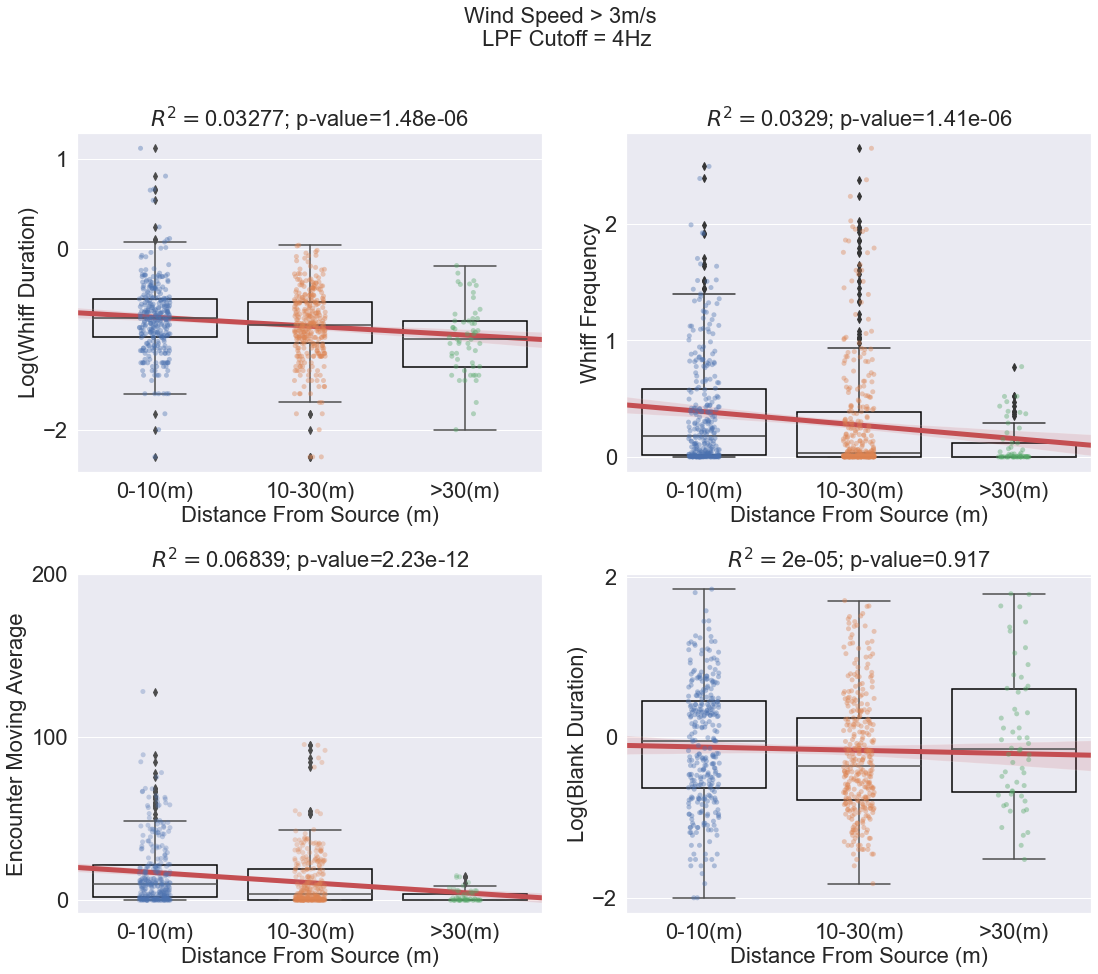

In [115]:
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(16,14)
                    ,gridspec_kw={'height_ratios':[1,1],'width_ratios': [1,1]})
## Log(Lenght of Whiffs)
sns.boxplot(x="distance_from_source_bin", y="log_whiff", 
            data=fdf,  dodge=True,  ax=ax1 )
boxplotfill(ax1)
sns.stripplot(x="distance_from_source_bin", y="log_whiff", 
            data=fdf, dodge='True', ax=ax1, alpha=0.4)
sns.regplot(x="bins_distance",y="log_whiff", data=fdf, 
            ax=ax1, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)


ax1.set_xlabel('Distance From Source (m)')
ax1.set_ylabel('Log(Whiff Duration)')
ax1.set_title('$R^2=$'+str(np.round(logwhiff.rsquared,5)) 
                   +'; p-value='+ str('{:.3g}'.format(logwhiff.pvalues.log_whiff)))
ax1.set_yticks([-2,0,1])

## Whiff Frequency
sns.boxplot(x="distance_from_source_bin", y="mean_encounter_frequency", 
            data=fdf,  dodge=True,  palette='viridis',ax=ax2 )
boxplotfill(ax2)    
sns.stripplot(x="distance_from_source_bin", y="mean_encounter_frequency", 
            data=fdf, dodge='True', ax=ax2, alpha=0.4)
sns.regplot(x="bins_distance",y="mean_encounter_frequency", data=fdf, 
            ax=ax2, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)

ax2.set_xlabel('Distance From Source (m)')
ax2.set_ylabel('Whiff Frequency')
ax2.set_yticks([0,1,2])
ax2.set_title('$R^2=$'+str(np.round(ef.rsquared,5)) 
                   +'; p-value='+ str('{:.3g}'.format(ef.pvalues.mean_encounter_frequency)))

#Intermittency Factor
sns.stripplot(x="distance_from_source_bin", y="mean_intermittency_factor", 
            data=fdf, dodge='True', ax=ax3, alpha=0.3)
sns.boxplot(x="distance_from_source_bin", y="mean_intermittency_factor", 
            data=fdf,  dodge=True, ax=ax3 )
boxplotfill(ax3)
sns.regplot(x="bins_distance",y="mean_intermittency_factor", data=fdf, 
            ax=ax3, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)

ax3.set_yticks([0,100,200])
ax3.set_xlabel('Distance From Source (m)')
ax3.set_ylabel('Encounter Moving Average')
ax3.set_title('$R^2=$'+str(np.round(ma.rsquared,5)) 
            +'; p-value='+ str('{:.3g}'.format(ma.pvalues.mean_intermittency_factor)))



#Blank Frequency
sns.stripplot(x="distance_from_source_bin", y="log_blank", 
            data=fdf, dodge='True',alpha=0.4, ax=ax4)
sns.boxplot(x="distance_from_source_bin", y="log_blank", 
            data=fdf,  dodge=True, ax=ax4 )
boxplotfill(ax4)
sns.regplot(x="bins_distance",y="log_blank", data=fdf, 
            ax=ax4, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)

ax4.set_yticks([-2,0,2])
ax4.set_xlabel('Distance From Source (m)')
ax4.set_ylabel('Log(Blank Duration)')
ax4.set_title('$R^2=$'+str(np.round(logblank.rsquared,5)) 
                   +'; p-value='+ str('{:.3g}'.format(logblank.pvalues.log_blank)))


f.suptitle('Wind Speed > 3m/s \n LPF Cutoff = 4Hz', fontsize='large')
f.tight_layout(pad=4.0)
figurefirst.mpl_functions.set_fontsize(f, 22)
# f.savefig('../../Figure/SimHW.jpeg') 
# f.savefig('../../Figure/HWFiltered.svg', format='svg',dpi=1200)

In [ ]:
# dir = '~/Documents/Myfil|es/DataAnalysis/data/Sprints/HighRes/'
# fdf = pd.read_hdf(dir+'WindyStatswithIF.h5')

In [ ]:
encounter_freq=smf.ols(formula='np.log10(mean_encounter_frequency) ~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
encounters=smf.ols(formula='log_whiff~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
intermittencies=smf.ols(formula='log_blank ~ np.abs(fdf.avg_perpendicular_intermittency) + np.abs(fdf.avg_parallel_intermittency)', data=fdf).fit()
oderivatives = smf.ols(formula='odor_derivative ~ np.abs(fdf.avg_perpendicular_intermittency) + np.abs(fdf.avg_parallel_intermittency)', data=fdf).fit()
intermittencyfact = smf.ols(formula='mean_intermittency_factor ~ np.abs(fdf.avg_perpendicular_intermittency) + np.abs(fdf.avg_parallel_intermittency)', data=fdf).fit()


print(intermittencyfact.summary())

                                OLS Regression Results                               
Dep. Variable:     mean_intermittency_factor   R-squared:                       0.004
Model:                                   OLS   Adj. R-squared:                  0.003
Method:                        Least Squares   F-statistic:                     5.442
Date:                       Thu, 04 Nov 2021   Prob (F-statistic):            0.00438
Time:                               11:18:00   Log-Likelihood:                -10500.
No. Observations:                       2941   AIC:                         2.101e+04
Df Residuals:                           2938   BIC:                         2.102e+04
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [ ]:
fdf['encounterfreq_resid']=encounter_freq.resid
fdf['encounter_resid'] = encounters.resid
fdf['intermittency_resid'] = intermittencies.resid
fdf['odorderivative_resid'] = oderivatives.resid
fdf['intermittencyfact_resid'] = intermittencyfact.resid

In [ ]:
distance=smf.ols(formula='avg_dist_from_source ~ odorderivative_resid + encounter_resid + encounterfreq_resid +  intermittencyfact_resid+ intermittency_resid', data=fdf).fit()
print(distance.summary())
# plt.rc('figure', figsize=(12, 6))
# plt.text(0.01, 0.05, str(distance.summary()), {'fontsize': 12}, fontproperties = 'monospace')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig('../../Figure/contwindyreg.jpeg')

                             OLS Regression Results                             
Dep. Variable:     avg_dist_from_source   R-squared:                       0.101
Model:                              OLS   Adj. R-squared:                  0.099
Method:                   Least Squares   F-statistic:                     65.88
Date:                  Thu, 04 Nov 2021   Prob (F-statistic):           2.20e-65
Time:                          11:18:06   Log-Likelihood:                -11137.
No. Observations:                  2940   AIC:                         2.229e+04
Df Residuals:                      2934   BIC:                         2.232e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Interc

In [ ]:
f, (ax1,ax2,ax3) = plt.subplots(3,1, figsize =(14,12)) 
#                             gridspec_kw={'height_ratios':[3,3],'width_ratios': [4,4]})

ax1.plot(df.time,df.odor, label='Odor Concentration')
ax1.set_ylabel('Odor(V)')
ax1.set_xlim(1500,1700)
ax1.set_yticks([0,5,10])
ax1.set_xticks([1500,1600,1700])

ax2.plot(df.time,df.intermittency_fraction, c = 'green', label='Intermittency Sliding Avg')
ax2.set_ylabel('ON(t)')
ax2.set_xlim(1500,1700)
ax2.set_yticks([0,1])
ax2.set_xticks([1500,1600,1700])


ax3.plot(df.time,df.intermittency_factor, c = 'black', label='Sliding Avg Smoothed (Exp Filter)')
ax3.set_ylabel('Encounter MA \n Smoothed')
ax3.set_xlabel('Time (seconds)')
ax3.set_xlim(1500,1700)
ax3.set_yticks([0,200])
ax3.set_xticks([1500,1600,1700])


# f.text(0.0001, 0.76, 'Odor (V)', va='center', rotation='vertical')
# f.text(0.0001, 0.3, 'Encounter Frequency', va='center', rotation='vertical')
lgd=f.legend(loc='upper left', bbox_to_anchor=(1, 0.9))
f.tight_layout(pad=4.0)
figurefirst.mpl_functions.set_fontsize(f, 22)
# f.savefig('../../Figure/EncFreq.jpeg', bbox_extra_artists=(lgd,), bbox_inches='tight') 
# f.savefig('../../Figure/MA.svg', format='svg',dpi=1200, bbox_extra_artists=(lgd,), bbox_inches='tight')